In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print(f'GPUs Available: {len(tf.config.list_physical_devices("GPU"))}')

GPUs Available: 1


In [2]:
normal = pd.read_hdf('./data/training_normal.h5')
faulty = pd.read_hdf('./data/training_faulty.h5')
mean = pd.read_hdf('./data/norm.h5', key='mean')
std = pd.read_hdf('./data/norm.h5', key='std')

normal_data = normal.iloc[:, 3:]

In [3]:
normal_data

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,120.41,0.34050,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,120.39,0.35374,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,120.41,0.35910,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,120.39,0.32469,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


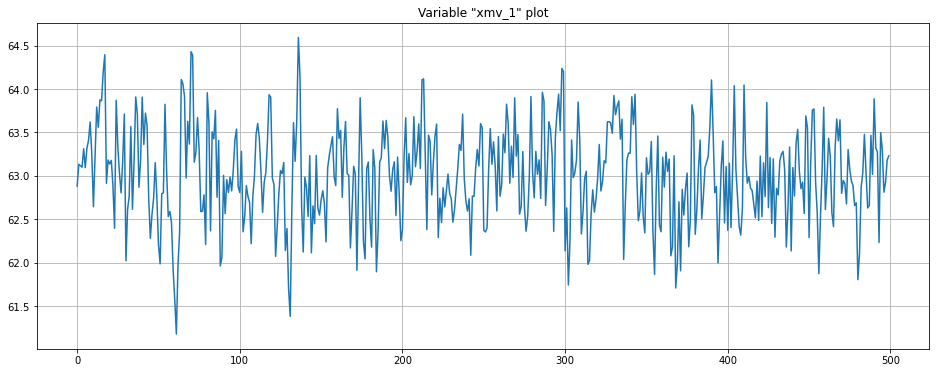

In [4]:
variable = 'xmv_1'

plt.figure(figsize=(16, 6))
plt.grid()
plt.plot(normal_data.index[:500], normal_data[variable][:500])
plt.title(f'Variable "{variable}" plot')
plt.show()

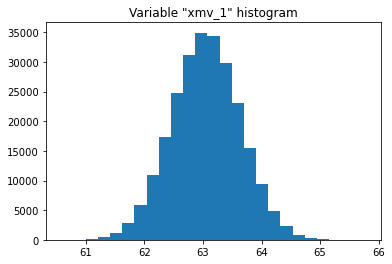

In [5]:
plt.hist(normal_data[variable], bins=25)
plt.title(f'Variable "{variable}" histogram')
plt.show()

## LSTM Autoencoder model

In [6]:
def to_sequences(data, seq_size=5, fault_number=0, fault=False):
    sequences = []
    
    for sim in data['simulationRun'].unique():
        if fault:
            sim_data = data[
                (data['faultNumber'] == fault_number) & 
                (data['simulationRun'] == sim) &
                (data['sample'] >= 20)
            ].iloc[:, 3:]
            
#             sim_data = data[
#                 (data['faultNumber'] == fault_number) & 
#                 (data['simulationRun'] == sim) &
#                 (data['sample'] >= 20)
#             ].filter(regex=r'^xmv')
        else:
            sim_data = data[
                (data['faultNumber'] == fault_number) & 
                (data['simulationRun'] == sim)
            ].iloc[:, 3:]
            
#             sim_data = data[
#                 (data['faultNumber'] == fault_number) & 
#                 (data['simulationRun'] == sim)
#             ].filter(regex=r'^xmv')
        
        sim_data = (sim_data - mean) / std
        for i in range(len(sim_data)-seq_size):
            sequences.append(sim_data.iloc[i:i+seq_size].values)
    return np.array(sequences)

x = to_sequences(normal)

In [7]:
train_data, valid_data = train_test_split(x, test_size=0.2, shuffle=False)
print(f'train data size: {train_data.shape}')
print(f'valid data size: {valid_data.shape}')

input_dims =  train_data.shape

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)

train data size: (198000, 5, 52)
valid data size: (49500, 5, 52)


In [ ]:
class LSTMAutoencoder(Model):
    def __init__(self, input_dims):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.LSTM(64, return_sequences=True, input_shape=(input_dims[1], input_dims[2])),
            layers.LSTM(32, return_sequences=True),
            layers.LSTM(8, return_sequences=False)
        ])

        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(input_dims[1]),
            layers.LSTM(8, return_sequences=True),
            layers.LSTM(32, return_sequences=True),
            layers.LSTM(64, return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dims[2]))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = LSTMAutoencoder(input_dims)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss=tf.losses.MeanSquaredError(), 
              metrics=[tf.metrics.MeanAbsoluteError()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)

In [ ]:
history = model.fit(train_data, train_data, 
                    epochs=200, 
                    batch_size=256, 
                    validation_data=(valid_data, valid_data), 
                    shuffle=True, 
                    callbacks=[reduce_lr, early_stopping])

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('L2 Loss')
plt.legend()

## Save model

In [ ]:
# Save model
val_loss = np.round(history.history["val_loss"][-1], decimals=4)
model.save(f'saved_model/lstm_ae_vars_{train_data.shape[2]}_loss_{str(val_loss)[2:]}')

## Load model

In [8]:
# Load model
model = tf.keras.models.load_model('saved_model/lstm_ae_loss_3725')

# Evaluate the restored model
mse, mae = model.evaluate(train_data, train_data, batch_size=200000, verbose=2)
print('Restored model, train MSE: {:.4f}'.format(mse))
print()
mse, mae = model.evaluate(valid_data, valid_data, batch_size=50000, verbose=2)
print('Restored model, valid MSE: {:.4f}'.format(mse))

1/1 - 2s - loss: 0.3596 - mean_absolute_error: 0.4203
Restored model, train MSE: 0.3596

1/1 - 0s - loss: 0.3725 - mean_absolute_error: 0.4276
Restored model, valid MSE: 0.3725


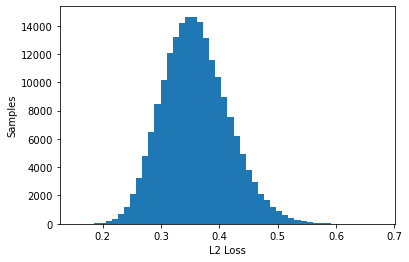

In [9]:
reconstructions = model.predict(train_data)
valid_reconstructions = model.predict(valid_data)

train_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(reconstructions, train_data), 1).numpy()
valid_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(valid_reconstructions, valid_data), 1).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("L2 Loss")
plt.ylabel("Samples")
plt.show()

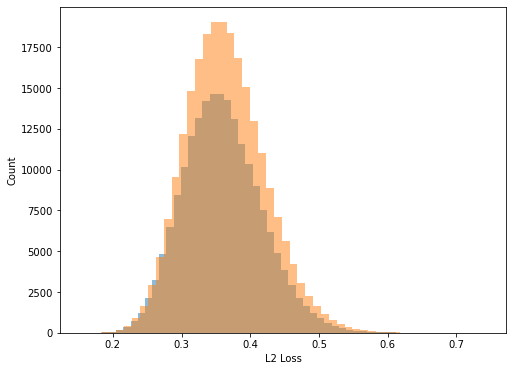

In [10]:
x_faulty = to_sequences(faulty, fault_number=3, fault=True)
faulty_data = tf.cast(x_faulty, tf.float32)

train_reconstructions = model.predict(train_data)
faulty_reconstructions = model.predict(faulty_data)

train_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(train_reconstructions, train_data), 1).numpy()
faulty_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(faulty_reconstructions, faulty_data), 1).numpy()

plt.figure(figsize=(8,6))
plt.hist(train_loss, bins=50, alpha=0.5, label='valid_loss')
plt.hist(faulty_loss, bins=50, alpha=0.5, label='faulty_loss')
plt.xlabel("L2 Loss")
plt.ylabel("Count")
plt.show()

In [ ]:
print(train_data.shape)
print(faulty_data.shape)

In [ ]:
data = tf.reshape(train_data[0:2], (-1, 5, 52))
print(data.shape)
print(valid_data.shape)

encoded_data = model.encoder(valid_data)
# print(encoded_data.shape)
encoded_data.shape

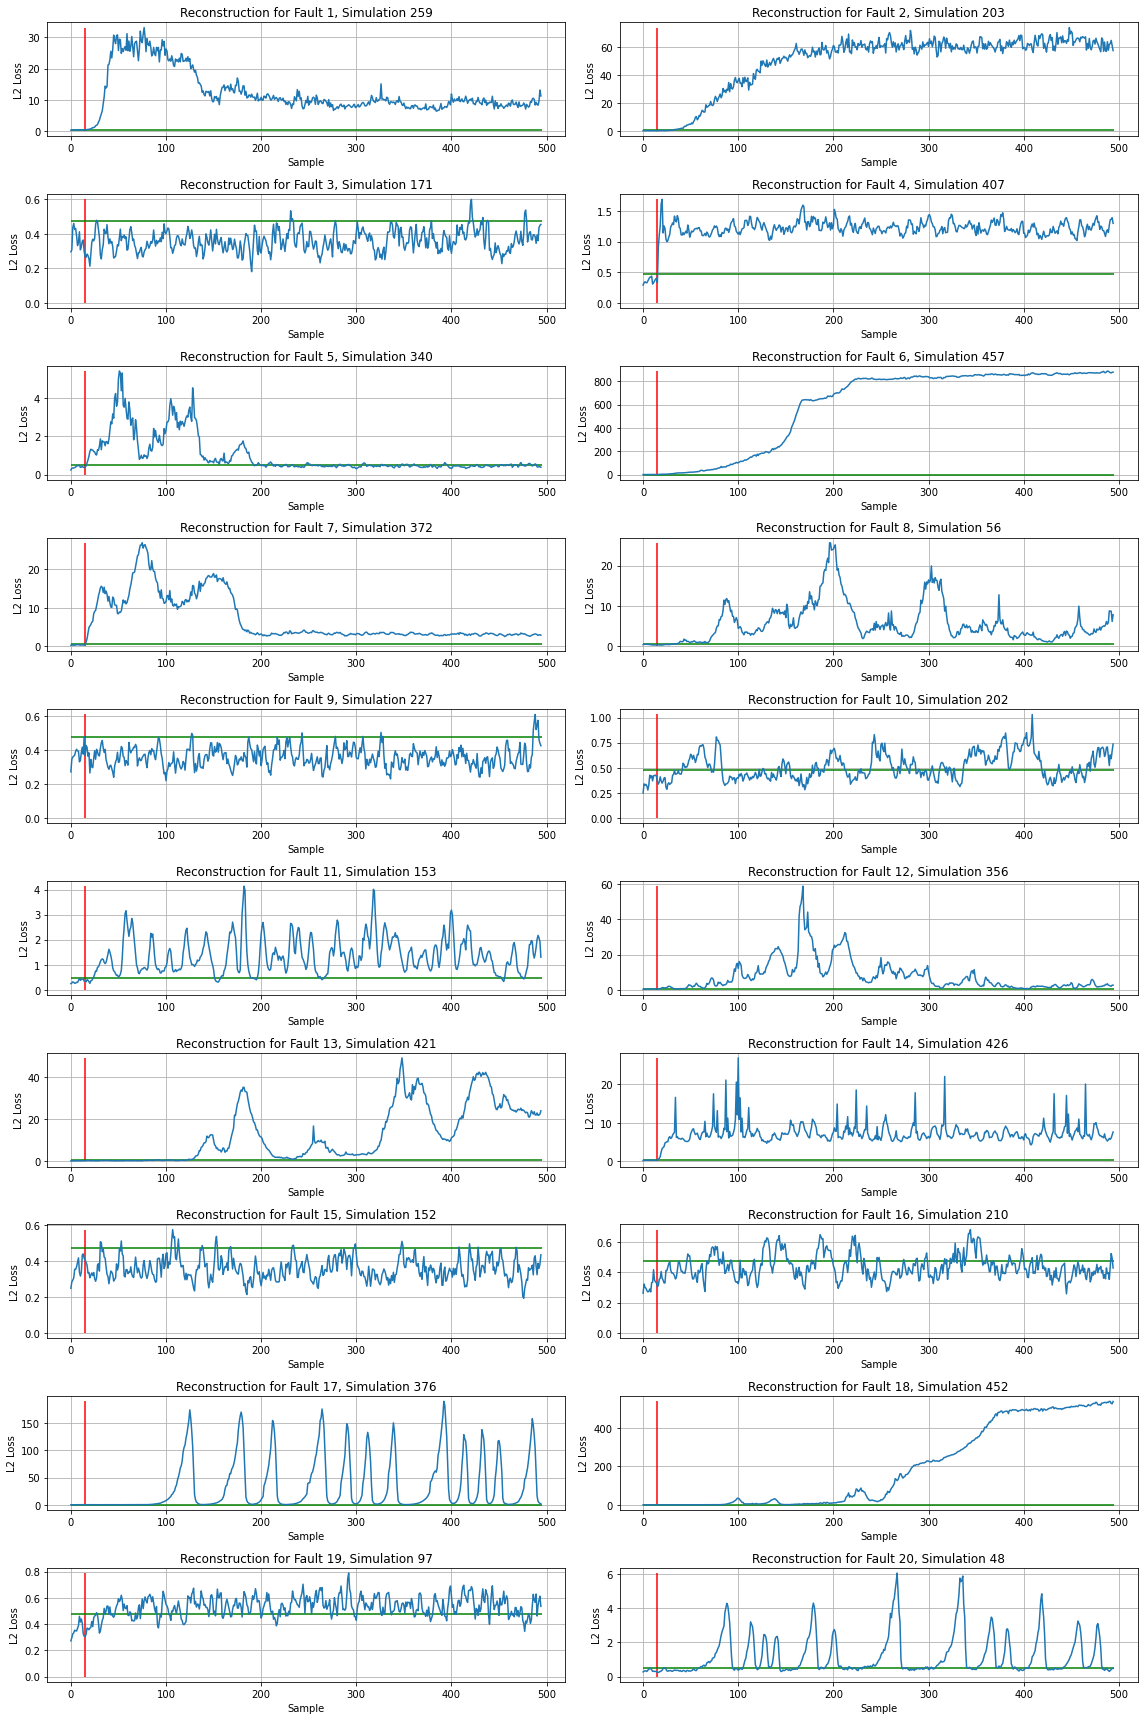

In [11]:
fig, axs = plt.subplots(10, 2, figsize=(16, 24))

for i in range(0, 20):
    row, col = divmod(i, 2)
    
    # Run model for fault simulation
    faultNumber = i+1
    simulationRun = np.random.randint(500)

    faulty_data = faulty[(faulty['faultNumber'] == faultNumber) & (faulty['simulationRun'] == simulationRun)]
    x_faulty = to_sequences(faulty_data, fault_number=faultNumber)
    x_faulty = tf.cast(x_faulty, tf.float32)

    reconstructions = model.predict(x_faulty)
    loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(reconstructions, x_faulty), 1).numpy()
    
    axs[row, col].grid()
    axs[row, col].plot(np.arange(x_faulty.shape[0]), loss)
    axs[row, col].set_title(f'Reconstruction for Fault {faultNumber}, Simulation {simulationRun}')
    axs[row, col].vlines([15], 0, np.max(loss), colors='r')
    axs[row, col].hlines([np.quantile(valid_loss, q=0.95)], 0, x_faulty.shape[0], colors='g')
    
for ax in axs.flat:
    ax.set(xlabel='Sample', ylabel='L2 Loss')
    
fig.tight_layout()
plt.show()

## Detecting fault

In [12]:
def to_sequences2(data, seq_size=5):
    sequences = []        
    data = (data - mean) / std
    for i in range(len(data)-seq_size):
        sequences.append(data.iloc[i:i+seq_size].values)
    return np.array(sequences)

normal_data = normal.iloc[:, 3:]
faulty_data = faulty[
    (faulty['simulationRun'] <= 20) & 
    (faulty['sample'] > 20)
].iloc[:, 3:]

norm_normal_data = (normal_data - mean) / std
norm_faulty_data = (faulty_data - mean) / std

x_normal = to_sequences2(norm_normal_data)[:20000]
x_faulty = to_sequences2(norm_faulty_data)[:20000]

print(norm_normal_data.shape)
print(norm_faulty_data.shape)

print(x_normal.shape)
print(x_faulty.shape)

(250000, 52)
(192000, 52)
(20000, 5, 52)
(20000, 5, 52)


In [13]:
normal_encoded = model.encoder(x_normal).numpy()
faulty_encoded = model.encoder(x_faulty).numpy()

normal_encoded = pd.DataFrame(normal_encoded, columns=[f'enc_{num+1}' for num in range(normal_encoded.shape[1])])
faulty_encoded = pd.DataFrame(faulty_encoded, columns=[f'enc_{num+1}' for num in range(faulty_encoded.shape[1])])
normal_encoded['fault'] = 0.0
faulty_encoded['fault'] = 1.0

data = pd.concat([normal_encoded, faulty_encoded], ignore_index=True)
data = data.sample(n=20000)
print(data['fault'].value_counts())
display(data)

0.0    10089
1.0     9911
Name: fault, dtype: int64


,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8,enc_9,enc_10,...,enc_24,enc_25,enc_26,enc_27,enc_28,enc_29,enc_30,enc_31,enc_32,fault
24726,0.399071,0.058447,-0.005774,-0.009635,0.041510,-0.091211,0.098637,0.047527,0.029565,-0.097160,...,0.006251,-0.097971,-0.025792,0.048929,-0.136099,-0.018941,-0.012919,-0.018303,-0.058401,1.0
24706,0.320566,0.059340,-0.010831,-0.018429,0.052743,-0.121928,0.072390,0.038109,0.028055,-0.052107,...,-0.004876,0.013412,-0.022305,0.037881,-0.145336,-0.028732,-0.051432,-0.025456,-0.034725,1.0
35693,0.197351,0.003524,-0.043760,-0.006836,0.049995,-0.077898,0.052894,0.049312,0.023537,-0.099091,...,-0.010691,-0.018062,-0.042443,0.038021,-0.155425,-0.030463,-0.033062,-0.014015,-0.047483,1.0
30756,0.184278,0.053802,0.026198,-0.014091,0.082779,-0.080688,0.033859,0.001841,0.022899,-0.033593,...,0.008049,0.004553,-0.003626,0.030749,-0.115145,-0.036008,-0.015452,-0.023091,-0.017113,1.0
2056,0.092959,0.096856,0.018750,-0.011026,0.054293,-0.104671,0.090894,0.028308,0.015611,-0.044463,...,-0.014623,-0.001057,-0.008412,0.039352,-0.127795,-0.054003,-0.015106,-0.028200,0.003372,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33564,0.093353,0.107778,0.041405,-0.008885,0.059629,-0.097840,0.087103,0.035692,0.010132,-0.048589,...,-0.007614,0.003828,-0.013307,0.033906,-0.133257,-0.056039,-0.022935,-0.032219,0.015796,1.0
22694,-0.153144,0.133039,0.075328,-0.000607,0.074070,-0.104703,-0.071328,0.058559,-0.017726,-0.106614,...,-0.002652,-0.031511,-0.029952,0.045374,-0.124827,-0.096969,0.052875,-0.013602,0.001063,1.0
38192,-0.260633,0.046053,-0.096208,-0.001769,0.093480,-0.044156,0.047988,0.017858,0.031229,-0.026847,...,0.029197,0.000745,-0.038912,-0.002864,-0.112923,-0.025261,-0.029555,-0.004851,-0.028479,1.0
23127,-0.324141,0.060179,-0.053661,-0.015510,0.047835,-0.046432,0.089261,0.017595,0.026597,-0.068892,...,0.014938,0.015871,-0.024639,0.053581,-0.148661,-0.013238,-0.090965,-0.018526,-0.062445,1.0


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

clf = SVC(C=1.0, kernel='rbf', gamma='auto', verbose=True)
clf.fit(X, y)

[LibSVM]

SVC(gamma='auto', verbose=True)

In [15]:
print(f'score: {clf.score(X, y)}')

score: 0.6228


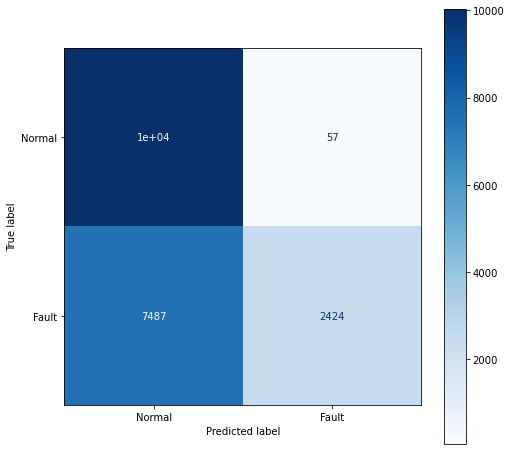

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf, X, y, display_labels=['Normal', 'Fault'], 
                      cmap=plt.cm.Blues, normalize=None, ax=ax);

In [17]:
normal_samples = 500
normal_kpi = clf.decision_function(normal_encoded.iloc[:normal_samples, :-1].values)

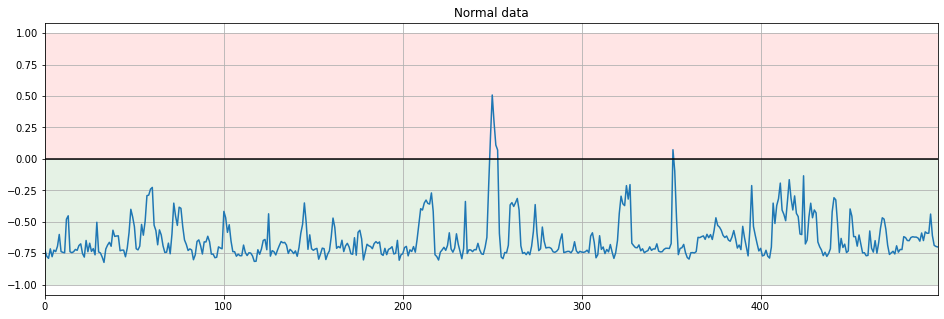

In [18]:
x = np.arange(normal_samples)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, np.tanh(normal_kpi))
ax.grid()
ax.axhline(color='black')
ax.fill_between(x, 0, -1, facecolor='green', alpha=0.1)
ax.fill_between(x, 0, 1, facecolor='red', alpha=0.1)
ax.margins(x=0, y=0.04)
ax.set_title('Normal data')
plt.show()

In [34]:
faultNumber = 2
simulationRun = np.random.randint(0, 500)

f_data = faulty[
    (faulty['faultNumber'] == faultNumber) & 
    (faulty['simulationRun'] == simulationRun)
].iloc[:, 3:]

nf_data = to_sequences2(f_data, seq_size=5)

f_encoded = model.encoder(nf_data).numpy()
faulty_kpi = clf.decision_function(f_encoded)

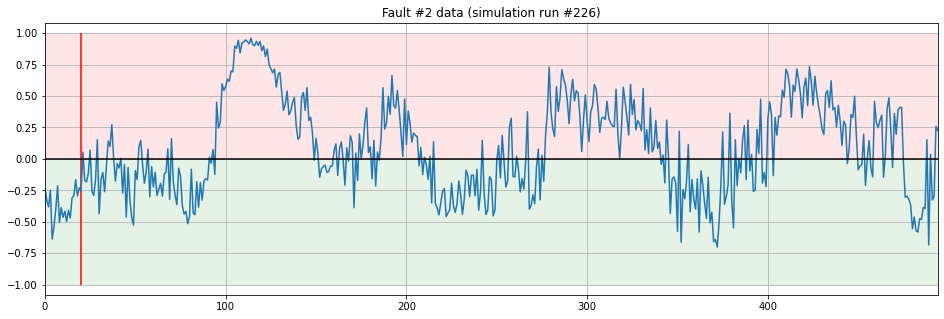

In [35]:
samples = 495
x = np.arange(samples)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, np.tanh(faulty_kpi))
ax.grid()
ax.axhline(color='black')
ax.fill_between(x, 0, -1, facecolor='green', alpha=0.1)
ax.fill_between(x, 0, 1, facecolor='red', alpha=0.1)
ax.vlines([20], -1, 1, colors='r')
ax.margins(x=0, y=0.04)
ax.set_title(f'Fault #{faultNumber} data (simulation run #{simulationRun})')
plt.show()